In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D 
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

import importlib.util
import os
import csv

import warnings
warnings.filterwarnings('ignore')

from scipy import cluster,stats
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.stats import hypergeom
import Levenshtein

from smer import load_smer_data, sdist_kmers, sdist_seq, colors


In [2]:
## datasets
folder = '../data/'

# Data
fn1 = 'dataset_sizes.csv'
fn3 = 'query_seqs_dframe.tsv' 
fn4 = 'anova_mob_data.csv'
fn5 = 'anova_pn_data.csv'
fn6 = 'align_found_sb.csv'
fn7 = 'align_found_len.csv'
fn8 = 'align_metrics_sb.csv'
fn9 = 'align_metrics_len.csv'
fn10 = 'align_mob_test.csv'
smer_dir = folder

# define variables
datasize1 = [135,110,100,80,60,40,0]
datasize2 = [145,150,160,170,180,200,220]
orit_sizes = list(zip(datasize1,datasize2))


In [3]:
## functions

def nt_complement(plus_seq):
    #https://en.wikipedia.org/wiki/Nucleic_acid_notation
    CODE={'A':'T','T':'A','C':'G','G':'C','R':'Y','Y':'R','N':'N','M':'K','K':'M'} 
    minus_seq=''
    for c in plus_seq:
        minus_seq=minus_seq+CODE[c]
    return minus_seq

def list_kmers(seq,k):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

def jaccard(s1,s2,k): # similarity => 1
    k1 = set(list_kmers(s1,k))
    k2 = set(list_kmers(s2,k))
    return 1-len(k1.intersection(k2))/len(k1.union(k2)) # distance

smer_dict, smer_distmat = load_smer_data(smer_dir)

def sjaccard(s1,s2,k,dic=smer_dict[2][-2]):
    k1 = set([dic[lis] for lis in list_kmers(s1,k)])
    #print(k1)
    k2 = set([dic[lis] for lis in list_kmers(s2,k)])
    #print(k2)
    return 1-len(k1.intersection(k2))/len(k1.union(k2)) # distance

def get_orit_distances(x1,x2,i1,i2):
    '''computes distances per row'''
    tmp = []
    #index = x.loc['index']
    k = 7
    skx = 2
    ck = [0,2,4,5]
    ck_names = [4,8,16,32,64,128,256]
    for ckx in ck:
        dic = smer_dict[skx][ckx]
        # edit distance
        tmp.append([i1,i2,'edit',k,ck_names[ckx],Levenshtein.distance(x1,x2)/len(x1)])

        # percent sequence identity = edit distance ratio * 100
        tmp.append([i1,i2,'seqid',k,ck_names[ckx],Levenshtein.ratio(x1,x2)])

        # jaccard distance
        tmp.append([i1,i2,'jacc',k,ck_names[ckx],jaccard(x1,x2,k)])

        # s-jaccard
        tmp.append([i1,i2,'sjacc',k,ck_names[ckx],sjaccard(x1,x2,k,dic)])

        tmp.append([i1,i2,'sedit',k,ck_names[ckx],(Levenshtein.distance(
            ''.join([chr(int(xx-1)) for xx in colors(x1,dic,k)]),
            ''.join([chr(int(xx-1)) for xx in colors(x2,dic,k)])))/len(colors(x1,dic,k))])

        tmp.append([i1,i2,'sseqid',k,ck_names[ckx],(Levenshtein.ratio(
            ''.join([chr(int(xx-1)) for xx in colors(x1,dic,k)]),
            ''.join([chr(int(xx-1)) for xx in colors(x2,dic,k)])))])
        
    #df = pd.DataFrame(tmp,columns=['i1','i2','measure','par_s','par_c','value'])
    #print(df)
    return tmp

def run_pairwise_dist(x):
    '''runs distance computation pairwise'''
    # series input
    # drop index / extract values
    x = x.values
    tmp = []
    for i in range(len(x)):
        # upper diagonal
        for j in range(i+1,len(x)):
            tmp.extend(get_orit_distances(x[i],x[j],i,j))
    df = pd.DataFrame(tmp,columns=['i1','i2','measure','par_s','par_c','value'])
    return df

def slice_orit(x,slic):
    x = x.values
    tmp = []
    for i in range(len(x)):
        tmp.append(x[i][slic[0]:slic[1]])
    return pd.Series(tmp)

def nt_complement(plus_seq):
    #https://en.wikipedia.org/wiki/Nucleic_acid_notation
    CODE={'A':'T','T':'A','C':'G','G':'C','R':'Y','Y':'R','N':'N','M':'K','K':'M'} 
    minus_seq=''
    for c in plus_seq:
        minus_seq=minus_seq+CODE[c]
    return minus_seq

def read_fasta_seqs(fname):
    seqs = []
    fasta_sequences = SeqIO.parse(open(fname),'fasta')
    for fasta in fasta_sequences:
        seqs.append(str.upper(str(fasta.seq)))
    return seqs

def extract_orit(row):
    if row.orientation == 'F':
        row['orit'] = row.full_sequence[int(row.nic_location)-140:int(row.nic_location)+80]
    if row.orientation == 'R':
        row['orit'] = row.full_sequence[int(row.nic_location)-80:int(row.nic_location)+140][::-1]
    if row.orientation == 'C':
        row['orit'] = nt_complement(row.full_sequence[int(row.nic_location)-140:int(row.nic_location)+80])
    if row.orientation == 'RC':
        row['orit'] = nt_complement(row.full_sequence[int(row.nic_location)-80:int(row.nic_location)+140])[::-1]
    return row

def extract_nic(row): # takes +-1 bp more due to offset for alignment
    if row.orientation == 'F':
        row['nic'] = row.full_sequence[int(row.nic_location)-5:int(row.nic_location)+5]
    if row.orientation == 'R':
        row['nic'] = row.full_sequence[int(row.nic_location)-5:int(row.nic_location)+5][::-1]
    if row.orientation == 'C':
        row['nic'] = nt_complement(row.full_sequence[int(row.nic_location)-5:int(row.nic_location)+5])
    if row.orientation == 'RC':
        row['nic'] = nt_complement(row.full_sequence[int(row.nic_location)-5:int(row.nic_location)+5])[::-1]
    return row


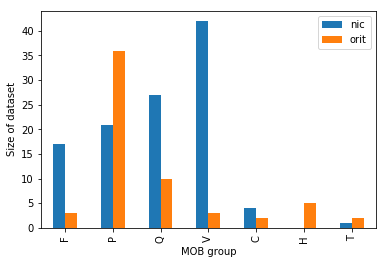

nic     0.647399
orit    0.352601
dtype: float64


In [4]:
# supp. figure datasets

table1 = pd.read_csv(folder+fn1).set_index('Unnamed: 0')
table1.plot.bar()
plt.ylabel('Size of dataset')
plt.xlabel('MOB group')
#plt.xticks(ticks=list(range(7)),labels=['F','P','Q','V','C','H','T'])
plt.show()

all1 = table1.sum().sum()
print(table1.sum().divide(all1))


## Distance func. analysis

### s-distance

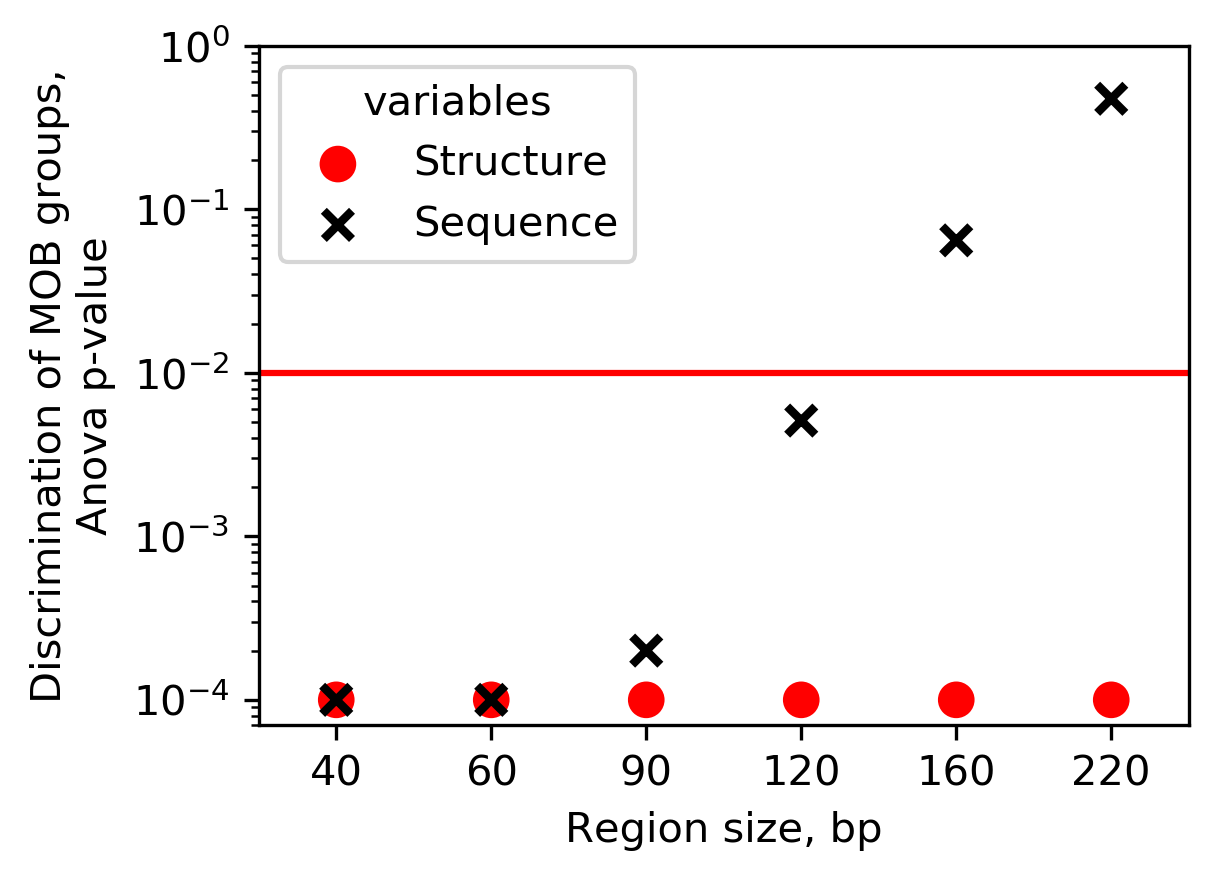

In [5]:
# import data / plot
columns = ['reg_start','reg_end',
           'seq_f','seq_pval',
           'str_f','str_pval']

df_mob = pd.read_csv(folder+fn4,header=None).transpose()
df_mob.columns=columns
df_mob['reg_size'] = (df_mob.reg_end.subtract(df_mob.reg_start)+1).astype(int)
# replace 0.0000 with 0.0001 cutoff based on num permutations
df_mob['seq_pval'] = df_mob.seq_pval.replace(to_replace=0, value=0.0001,)
df_mob['str_pval'] = df_mob.str_pval.replace(to_replace=0, value=0.0001,)
df_mob

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))

df_plot = (df_mob
           .rename(columns={'seq_pval':'Sequence',
                       'str_pval':'Structure'})
           .melt(id_vars=['reg_size'], 
                 value_vars=['Structure','Sequence'])
          )

sns.pointplot(data=df_plot,x='reg_size',y='value',
            hue='variable',markers=['o','x'],
          palette=['r','k'],join=False)

# mark significance cutoff
plt.plot([-1,10],[0.01,0.01],'r',zorder=0)
plt.xlim(-0.5,5.5)

plt.yscale('log')
plt.ylabel('Discrimination of MOB groups,\nAnova p-value')
plt.xlabel('Region size, bp')
plt.ylim(0.00007,1)
plt.legend(title='variables')
plt.savefig('f1c.svg')


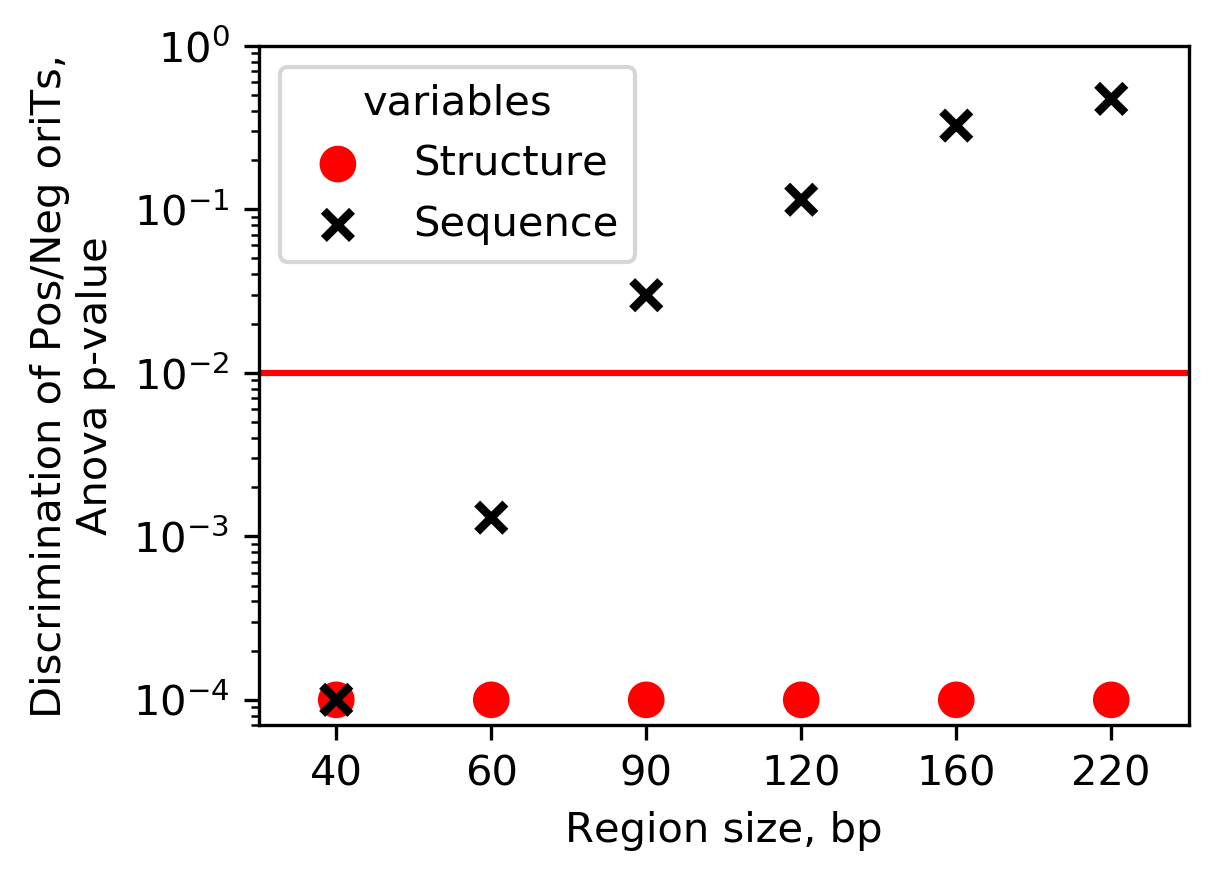

In [6]:
df_pn = pd.read_csv(folder+fn5,header=None).transpose()
df_pn.columns=columns
df_pn['reg_size'] = (df_pn.reg_end.subtract(df_pn.reg_start)+1).astype(int)
# replace 0.0000 with 0.0001 cutoff based on num permutations
df_pn['seq_pval'] = df_pn.seq_pval.replace(to_replace=0, value=0.0001,)
df_pn['str_pval'] = df_pn.str_pval.replace(to_replace=0, value=0.0001,)
df_pn.head()

plt.figure(figsize=(4,3))

df_plot = (df_pn
           .rename(columns={'seq_pval':'Sequence',
                       'str_pval':'Structure'})
           .melt(id_vars=['reg_size'], 
                 value_vars=['Structure','Sequence'])
          )

sns.pointplot(data=df_plot,x='reg_size',y='value',
            hue='variable',markers=['o','x'],
          palette=['r','k'],join=False)

# mark significance cutoff
plt.plot([-1,10],[0.01,0.01],'r',zorder=0)
plt.xlim(-0.5,5.5)

plt.yscale('log')
plt.ylabel('Discrimination of Pos/Neg oriTs,\nAnova p-value')
plt.xlabel('Region size, bp')
plt.ylim(0.00007,1)
plt.legend(title='variables')
plt.savefig('f1b.svg')


### Jaccard

In [7]:
## load data

# orit query
orit_seqs = pd.read_csv(folder+fn3,sep='\t',header=None)
orit_seqs.columns = ['plasmid_name','mob','mob_subgroup','nic','exp_nic','exp_orit','refs','genbank','nic_location','orit']

print(orit_seqs[orit_seqs.mob.isin(['C','T'])].nic)

# mob C and T nics are RC - fix
for idx,row in orit_seqs[orit_seqs.mob.isin(['C','T'])].iterrows():
    nic = nt_complement(row.nic[::-1])
    print(row.orit.find(nic))
    orit_seqs.at[idx,'nic'] = nic
    
print(orit_seqs[orit_seqs.mob.isin(['C','T'])].nic)

orit_seqs.head()


34     CCGACCACCC
35     TGACCATTTT
36     CTGTTAGCGT
110    GTGACCACCC
111    TGACCATTTT
Name: nic, dtype: object
135
135
135
135
135
34     GGGTGGTCGG
35     AAAATGGTCA
36     ACGCTAACAG
110    GGGTGGTCAC
111    AAAATGGTCA
Name: nic, dtype: object


,plasmid_name,mob,mob_subgroup,nic,exp_nic,exp_orit,refs,genbank,nic_location,orit
0,R388,F,11,TGTCTATAGC,E,E,"(Llosa et al., 1995)",BR000038,16173..16174,TTACTGTAGTGGTTCAATCCTAGCATTTACAAGGGGTTGCGGCAAT...
1,R100,F,12,GTGTGTGGTG,E,E,"(Abo and Ohtsubo, 1995; Innamoto et al., 1991)",NC_002134,50566..50567,TAATAAGAGTCGCTATAGGGTCGTAACAGGATCGCCAACGACTCTC...
2,R1,F,12,GGTGTGGTGC,E,E,"(Sut et al., 2009)",X00783.1,334..335,CGTTAAATTCATTGGTGAATCATATGCGATTCACCAATGAATCCTT...
3,F,F,12,GGTGTGGTGC,E,E,"(Matson and Morton, 1991; Reygers et al., 1991)",NC_002483,66156..66157,ACAAAACGGTGTCGGCGCGTTGTTGTAGCCGCGCCGACACCGCTTT...
4,RP4/pTB11/pBS228,P,11,TCCTGCCCGG,E,E,"(Pansegrau et al., 1988)",X54459.1,4743..4744,TCCGCTTGCCCTCATCTGTTACGCCGGCGGTAGCCGGCCAGCCTCG...


In [8]:
# Plot jaccard s-jaccard

## rerun get whole data
# slice data 
# compare jacc to sjacc at each size of region
# compare to itself between sizes of regions 

res = []
for slic in orit_sizes:
    grouped = orit_seqs[orit_seqs.mob.isin(['F','P','Q','V'])].groupby('mob')
    df = grouped.orit.apply(lambda x: run_pairwise_dist(slice_orit(x,slic)))
    df['region_size'] = slic[1]-slic[0]
    res.append(df)

res = pd.concat(res)
print(res.shape)


(261744, 7)


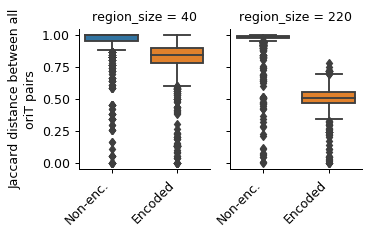

In [9]:
# box plots
mpl.rcParams['figure.dpi'] = 90
df_plot = res[(res.par_c==128) & 
              (res.measure.isin(['jacc','sjacc'])) &
              (res.region_size>10)]

g = sns.catplot(x='measure',y='value',col="region_size",
                data=df_plot[df_plot.region_size.isin([40,220])],
                kind="box", height=2.5, aspect=.8,
                order=['jacc','sjacc'])

g.axes.flat[0].set_ylabel('Jaccard distance between all\noriT pairs')
g.set_xticklabels(('Non-enc.','Encoded'),
                   rotation=45,ha='right')
for ax in g.axes.flat:
    ax.set_xlabel('')


In [10]:
## stats show all changes betweeen sjacc region size are significant p<1e-27
# whereas this is not so with jacc
# at all region sizes sjacc and jacc are significantly diff p<1e-9
#
# stats
df_stats_comp = (df_plot
 .groupby('region_size')
 .apply(lambda x: stats.ranksums(x[x.measure=='jacc']['value'].values,x[x.measure=='sjacc']['value'].values))
)
print(df_stats_comp)

# between reigons
tmp_jacc = []
tmp_sjacc = []
for i in range(len(df_plot.region_size.unique())):
    for j in range(i+1,len(df_plot.region_size.unique())):
        a = df_plot[df_plot.region_size==df_plot.region_size.unique()[i]]
        b = df_plot[df_plot.region_size==df_plot.region_size.unique()[j]]
        tmp = list(stats.ranksums(a[a.measure=='jacc']['value'].values,b[b.measure=='jacc']['value'].values))      
        tmp_jacc.append([df_plot.region_size.unique()[i],df_plot.region_size.unique()[j],tmp])
        tmp = list(stats.ranksums(a[a.measure=='sjacc']['value'].values,b[b.measure=='sjacc']['value'].values))
        tmp_sjacc.append([df_plot.region_size.unique()[i],df_plot.region_size.unique()[j],tmp])

df_stats = pd.DataFrame(tmp_jacc,columns=['i','j','stats_jacc'])
tmp = pd.DataFrame(tmp_sjacc,columns=['i','j','stats_sjacc'])
df_stats['stats_sjacc'] = tmp['stats_sjacc']
df_stats


region_size
40     (37.5092278938535, 6.514511392254386e-308)
60                       (41.57521149498129, 0.0)
90                       (44.63788621810433, 0.0)
120                     (45.264152790607156, 0.0)
160                     (45.839801906517124, 0.0)
220                      (46.47807568843203, 0.0)
dtype: object


,i,j,stats_jacc,stats_sjacc
0,40,60,"[0.06602969553970878, 0.9473541834151992]","[11.027775565721575, 2.807226033909102e-28]"
1,40,90,"[1.9026150117984422, 0.05709079888141371]","[26.45108583666689, 3.545292243411347e-154]"
2,40,120,"[3.7141504616551995, 0.00020388746527524114]","[36.18305849610181, 1.1244913514762448e-286]"
3,40,160,"[5.796077116497996, 6.7884057876984764e-09]","[40.943011011359395, 0.0]"
4,40,220,"[8.148852962755484, 3.6739233128209526e-16]","[43.45703790540957, 0.0]"
5,60,90,"[1.406038248418087, 0.15971276741192308]","[20.365879896514926, 3.357671267807963e-92]"
6,60,120,"[2.66607838836297, 0.00767417967942593]","[34.66373830017908, 2.773713348982361e-263]"
7,60,160,"[6.135006986154624, 8.515545192284683e-10]","[41.13902920282287, 0.0]"
8,60,220,"[9.462059353330952, 3.019370983829032e-21]","[43.78244721919423, 0.0]"
9,90,120,"[1.3652774562679713, 0.172165861723087]","[22.725047640320135, 2.5335444514852205e-114]"


In [11]:
# perc change jaccard
tmp = df_plot.groupby(['measure','region_size']).median()
print(1-tmp.loc[['sjacc',40]].value[1]/tmp.loc[['sjacc',40]].value[0])


0.03703703703703709


## Analysis of alignment results

### Perc. found

In [12]:
# define vars
cols1 = ['cv106','cv106_b',
        'ori51','ori51_b',
        'relax410','relax410_b']
index1 = ['Orit region','Mob group','Mob subgroup']
index2 = ['TPR','TNR','PPV',
           'Acc','F1','MCC']
index2  = [it for el in [index2 for i in range(3)] for it in el]
cols2 = ['cv106_220','cv106_40',
        'ori51_220','ori51_40',
        'relax410_220','relax410_40']
lens = pd.DataFrame([[106,51]],columns=['cv106','ori51'])


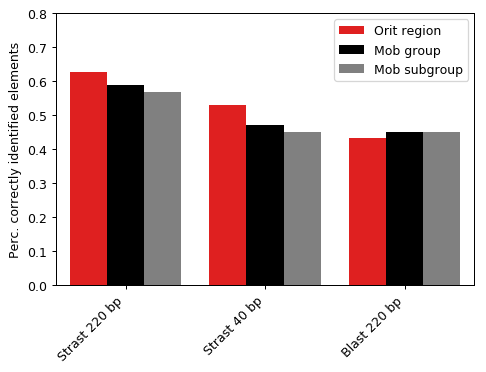

In [13]:
# fig s1-5 - separate experiments
df_sb = pd.read_csv(folder+fn6,names=cols1)
df_sb['exp'] = index1
df_len = pd.read_csv(folder+fn7,names=cols2)
df_len['exp'] = index1

df_exp = df_sb.melt(id_vars='exp',value_vars=['cv106','ori51','cv106_b','ori51_b'])
df_tmp = df_len.melt(id_vars='exp',value_vars=['cv106_40','ori51_40'])
df_exp = df_exp.append(df_tmp)
tmp = [['Strast 220 bp' for i in range(6)],
                 ['Blast 220 bp' for i in range(6)],
                 ['Strast 40 bp' for i in range(6)]]
df_exp['type'] = [it for el in tmp for it in el] 
df_exp['variable'] = df_exp.variable.apply(lambda x: x.split('_')[0])

for col in ['cv106','ori51']:
    df_exp.at[df_exp.variable==col,'value'] = (df_exp
                                               .loc[df_exp.variable==col,'value']
                                               .divide(lens[col][0])
                                               .values)
df_exp

# #plt.figure(figsize=(3,3))
# sns.barplot(data=df_exp[df_exp.variable=='cv106'],
#            x='type',y='value',
#            hue='exp',palette=['r','k','grey'],
#            order=['Strast 220 bp','Strast 40 bp','Blast 220 bp'])
# plt.ylabel('Perc. correctly identified elements')
# plt.xlabel('')
# plt.ylim(0,0.8)
# plt.legend()
# plt.xticks(rotation=45,ha='right')
# plt.title('Query set 10-fold CV')
# plt.show()

sns.barplot(data=df_exp[df_exp.variable=='ori51'],
           x='type',y='value',
           hue='exp',palette=['r','k','grey'],
           order=['Strast 220 bp','Strast 40 bp','Blast 220 bp'])
plt.ylabel('Perc. correctly identified elements')
plt.xlabel('')
plt.ylim(0,0.8)
plt.legend()
plt.xticks(rotation=45,ha='right')
#plt.title('Testing set (Mob typed)')
plt.show()


In [14]:
print(df_exp[(df_exp.type=='Strast 220 bp')&
       (df_exp.exp.isin(['Orit region','Mob group']))]
 .groupby('exp')
 .value
 .mean()
)
print(df_exp[(df_exp.type=='Strast 220 bp')&
       (df_exp.exp.isin(['Orit region','Mob group']))]
 .groupby('variable')
 .value
 .mean()
)

exp
Mob group      0.539401
Orit region    0.525990
Name: value, dtype: float64
variable
cv106    0.457547
ori51    0.607843
Name: value, dtype: float64


### Perc. found increases

In [15]:
# Compared to blast
df_sb = pd.read_csv(folder+fn6,names=cols1)
df_sb['exp'] = index1

df_exp = df_sb.melt(id_vars='exp',value_vars=['cv106','ori51','cv106_b','ori51_b'])
tmp = [['Strast 220 bp' for i in range(6)],
                 ['Blast 220 bp' for i in range(6)]]
df_exp['type'] = [it for el in tmp for it in el] 
df_exp['variable'] = df_exp.variable.apply(lambda x: x.split('_')[0])

for col in ['cv106','ori51']:
    df_exp.at[df_exp.variable==col,'value'] = (df_exp
                                               .loc[df_exp.variable==col,'value']
                                               .divide(lens[col][0])
                                               .values)
df_exp

df_perc = df_exp[(df_exp.type=='Strast 220 bp')]
df_perc['vs_blast'] = (df_exp[(df_exp.type=='Strast 220 bp')]
 .reset_index(drop=True)
 .value
 .divide(df_exp[(df_exp.type=='Blast 220 bp')]
        .reset_index(drop=True)
        .value)
 .subtract(1)
 .values
)
df_perc.query('variable=="ori51"').groupby('exp').vs_blast.mean()

exp
Mob group       0.304348
Mob subgroup    0.260870
Orit region     0.454545
Name: vs_blast, dtype: float64

In [16]:
# Region size
df_sb = pd.read_csv(folder+fn7,names=cols2)
df_sb['exp'] = index1

df_exp = df_sb.melt(id_vars='exp',value_vars=['cv106_220','ori51_220','cv106_40','ori51_40'])
tmp = [['Strast 220 bp' for i in range(6)],
                 ['Strast 40 bp' for i in range(6)]]
df_exp['type'] = [it for el in tmp for it in el] 
df_exp['variable'] = df_exp.variable.apply(lambda x: x.split('_')[0])

for col in ['cv106','ori51']:
    df_exp.at[df_exp.variable==col,'value'] = (df_exp
                                               .loc[df_exp.variable==col,'value']
                                               .divide(lens[col][0])
                                               .values)
df_exp

#df_perc = df_exp[(df_exp.type=='Strast 220 bp')]
df_perc['vs_40bp'] = (df_exp[(df_exp.type=='Strast 220 bp')]
 .reset_index(drop=True)
 .value
 .divide(df_exp[(df_exp.type=='Strast 40 bp')]
        .reset_index(drop=True)
        .value)
 .subtract(1)
 .values
)
df_perc.query('variable=="ori51"').groupby('exp').vs_40bp.mean()


exp
Mob group       0.250000
Mob subgroup    0.260870
Orit region     0.185185
Name: vs_40bp, dtype: float64

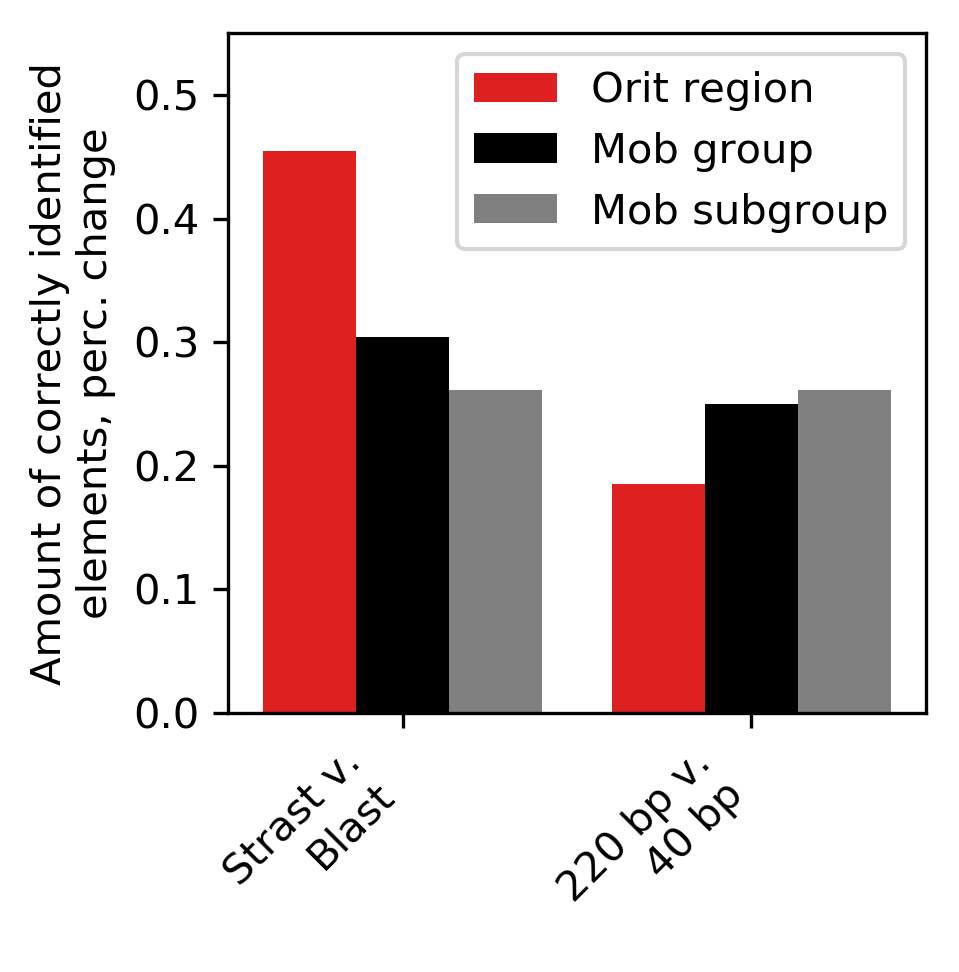

In [17]:
# Plot
df_plot = (df_perc
           .rename(columns={'variable':'type'})
           .melt(id_vars=['exp'],value_vars=['vs_40bp','vs_blast'])
          )
df_plot['type'] = [it for el in [df_perc.variable.values for i in range(2)] for it in el]
df_plot

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
ax = sns.barplot(data=df_plot[df_plot.type=='ori51'],
                 x='variable',y='value',
            hue='exp',palette=['r','k','grey'],
            ci=95, order=['vs_blast','vs_40bp'])
ax.set_xticklabels(labels=['Strast v.\nBlast',
                           '220 bp v.\n40 bp'],
                  rotation=45,ha='right')
plt.xlabel('')
plt.ylabel('Amount of correctly identified\nelements, perc. change')
plt.legend(loc=1)
plt.ylim(0,0.55)
plt.savefig('f1e.svg')


### Performance metrics

In [18]:
# Compared to blast
df_sb = pd.read_csv(folder+fn8,names=cols1)
df_sb['measure'] = index2

df_exp = df_sb.melt(id_vars='measure',value_vars=['cv106','ori51','cv106_b','ori51_b'])
# experiment
tmp = [[index1[0] for i in range(6)],
       [index1[1] for i in range(6)],
       [index1[2] for i in range(6)]]
tmp = [[it for el in tmp for it in el] for i in range(4)]        
df_exp['exp'] = [it for el in tmp for it in el] 
# type
tmp = [['Strast 220 bp' for i in range(36)],
                 ['Blast 220 bp' for i in range(36)]]
df_exp['type'] = [it for el in tmp for it in el] 
df_exp['variable'] = df_exp.variable.apply(lambda x: x.split('_')[0])

df_exp

# across orit region and mob group
df_perc = df_exp[(df_exp.type=='Strast 220 bp')]
df_perc['vs_blast'] = (df_exp[(df_exp.type=='Strast 220 bp')]
 #.query("exp.isin(['Orit region','Mob group'])")
 .reset_index(drop=True)
 .value
 .divide(df_exp[(df_exp.type=='Blast 220 bp')]
        .reset_index(drop=True)
        .value)
 .subtract(1)
 .values
)

(df_perc[df_perc
         .exp
         .isin(['Orit region','Mob group'])]
 .query('variable=="ori51"')
 .groupby('measure')
 .vs_blast
 .mean()
)

measure
Acc    0.338892
F1     0.273203
MCC    0.983531
PPV    0.014299
TNR    0.012146
TPR    0.552817
Name: vs_blast, dtype: float64

In [19]:
# Region size
df_sb = pd.read_csv(folder+fn9,names=cols2)
df_sb['measure'] = index2

df_exp = df_sb.melt(id_vars='measure',value_vars=['cv106_220','ori51_220','cv106_40','ori51_40'])
# experiment
tmp = [[index1[0] for i in range(6)],
       [index1[1] for i in range(6)],
       [index1[2] for i in range(6)]]
tmp = [[it for el in tmp for it in el] for i in range(4)]        
df_exp['exp'] = [it for el in tmp for it in el] 
# type
tmp = [['Strast 220 bp' for i in range(36)],
                 ['Strast 40 bp' for i in range(36)]]
df_exp['type'] = [it for el in tmp for it in el] 
df_exp['variable'] = df_exp.variable.apply(lambda x: x.split('_')[0])

df_exp

# across orit region and mob group
#df_perc = df_exp[(df_exp.type=='Strast 220 bp')]
df_perc['vs_40bp'] = (df_exp[(df_exp.type=='Strast 220 bp')]
 #.query("exp.isin(['Orit region','Mob group'])")
 .reset_index(drop=True)
 .value
 .divide(df_exp[(df_exp.type=='Strast 40 bp')]
        .reset_index(drop=True)
        .value)
 .subtract(1)
 .values
)

(df_perc[df_perc
         .exp
         .isin(['Orit region','Mob group'])]
 .query('variable=="ori51"')
 .groupby('measure')
 .vs_40bp
 .mean()
)

measure
Acc    0.195703
F1     0.153473
MCC    0.604959
PPV    0.002723
TNR    0.007021
TPR    0.316761
Name: vs_40bp, dtype: float64

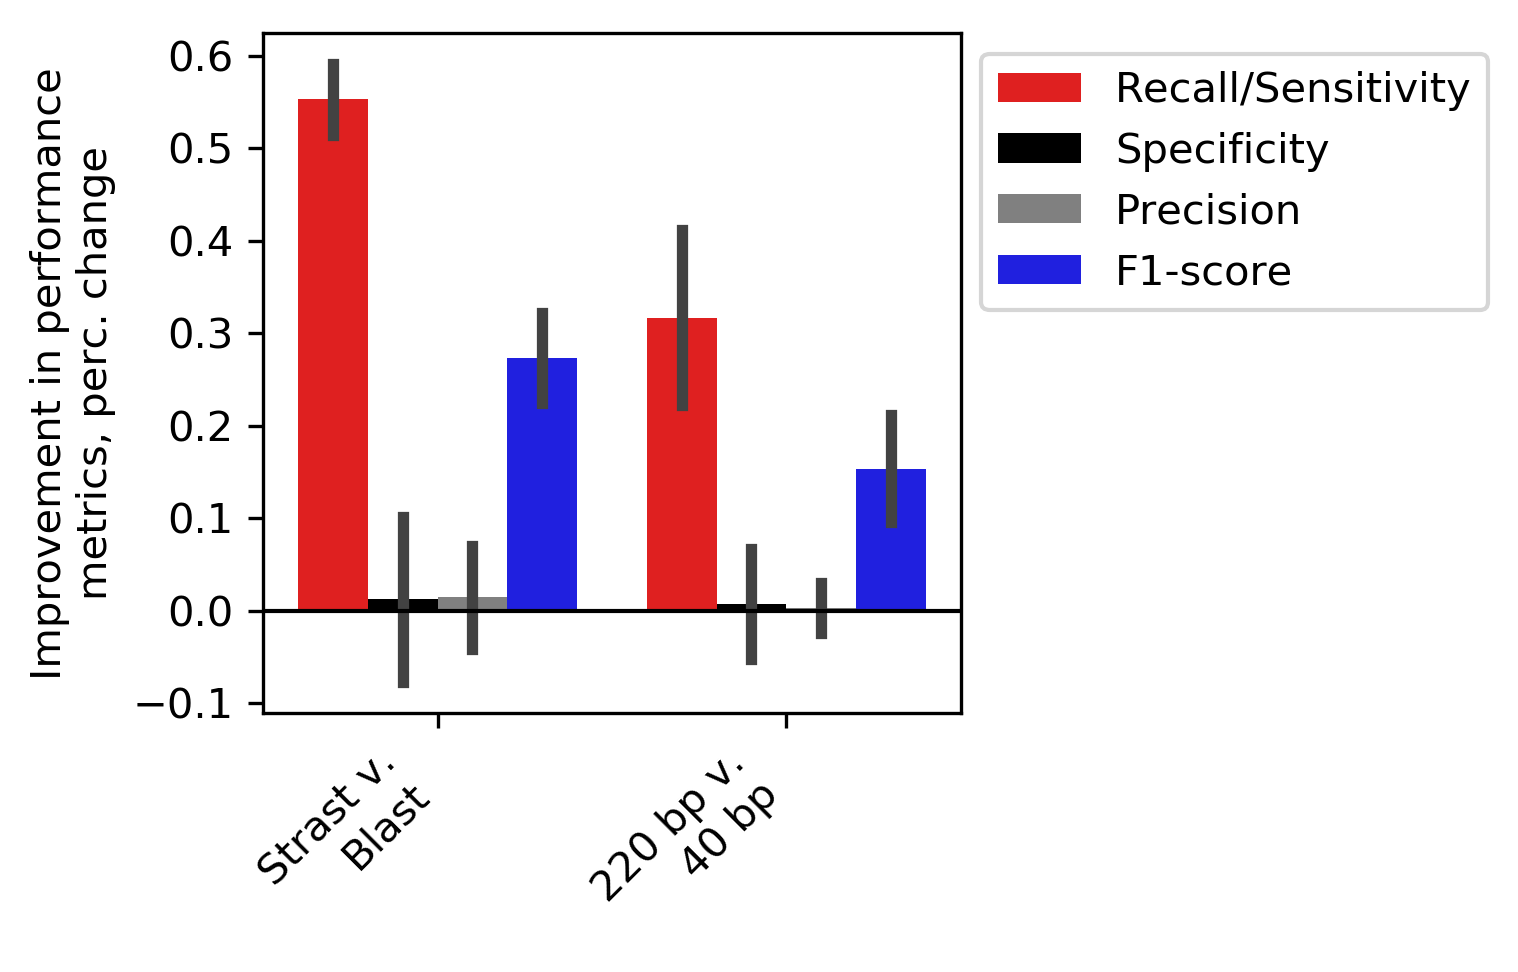

In [20]:
names1 = {'TPR':'Recall/Sensitivity',
    'TNR':'Specificity',
    'PPV':'Precision',
    'F1':'F1-score'}
df_perc['measure'] = df_perc.measure.replace(names1)

# Plot - average across both experiments
df_tmp = df_perc[(df_perc.exp.isin(['Orit region','Mob group']))&
                   (df_perc.measure.isin(list(names1.values())))]
df_plot = (df_tmp
           .melt(id_vars=['measure','exp'],
                 value_vars=['vs_40bp','vs_blast'])
          )
df_plot['var'] = [it for el in [df_tmp.variable.values for i in range(2)] for it in el]
df_plot

plt.figure(figsize=(3,3))
ax = sns.barplot(data=df_plot.query('var=="ori51"'),
                 x='variable',y='value',
            hue='measure',palette=['r','k','grey','b'],
            ci=95, order=['vs_blast','vs_40bp'])
ax.set_xticklabels(labels=['Strast v.\nBlast',
                           '220 bp v.\n40 bp'],
                  rotation=45,ha='right')
plt.plot([-10,10],[0,0],'k',linewidth=1)
plt.xlabel('')
plt.ylabel('Improvement in performance\nmetrics, perc. change')
plt.xlim(-0.5,1.5)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('f1f.svg')


In [21]:
# average recall
np.mean([0.316761,0.552817])

0.434789

### Mob groups recovery

(51, 4)


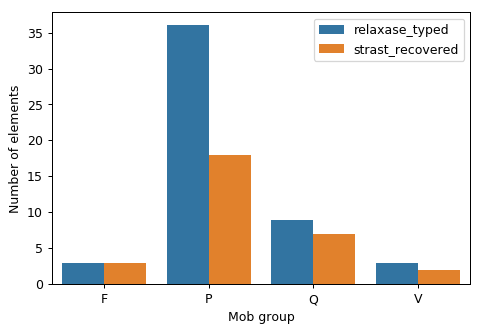

0.5882352941176471


In [22]:
# Perc found per mob group sum across both exp
cols = ['plasmid_name','submob_typed','submob_strast','pval']

df_mob = pd.read_csv(folder+fn10,names=cols)
# df_mob = (df_mob
#           .append(pd.read_csv(folder+fn11,names=cols))
#          )
# df_mob = (df_mob
#           .append(pd.read_csv(folder+fn12,names=cols))
#          )
print(df_mob.shape)

# get mob
df_mob['mob_typed'] = (df_mob
                      .submob_typed
                      .apply(lambda x: x[0])
                     )
df_mob['mob_strast'] = (df_mob
                      .submob_strast
                      .apply(lambda x: x[0])
                     )
# correctness
df_mob['mob_true'] = (df_mob.mob_strast==df_mob.mob_typed)&(df_mob.pval<-10)
df_mob['submob_true'] = (df_mob.submob_strast==df_mob.submob_typed)&(df_mob.pval<-10)
df_mob.head()

# metrics
mpl.rcParams['figure.dpi'] = 90
df_plot = (df_mob
           .groupby('mob_typed')
           .plasmid_name
           .count()
           .reset_index()
           )
df_plot['mob_true'] = (df_mob
                       .groupby('mob_typed')
                       .mob_true
                       .sum()
                       .astype(int)
                       .values
                      )
sns.barplot(data=(df_plot
                  .rename(columns={'plasmid_name':'relaxase_typed',
                                   'mob_true':'strast_recovered'})
                  .melt(id_vars='mob_typed',
                        value_vars=['relaxase_typed',
                                    'strast_recovered'])
                 ),
            x='mob_typed',y='value',
           hue='variable')
plt.legend()
plt.xlabel('Mob group')
plt.ylabel('Number of elements')
plt.show()
print(df_mob.mob_true.sum()/df_mob.shape[0])


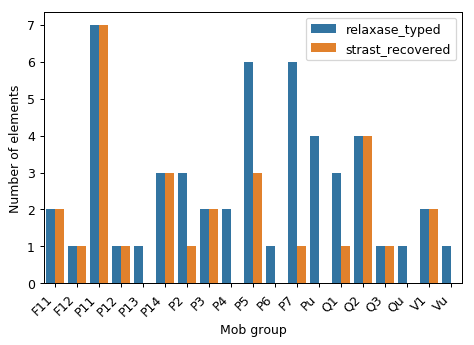

In [23]:
# subgrops
df_plot = (df_mob
           .groupby('submob_typed')
           .plasmid_name
           .count()
           .reset_index()
           )
df_plot['submob_true'] = (df_mob
                       .groupby('submob_typed')
                       .submob_true
                       .sum()
                       .astype(int)
                       .values
                      )
sns.barplot(data=(df_plot
                  .rename(columns={'plasmid_name':'relaxase_typed',
                                   'submob_true':'strast_recovered'})
                  .melt(id_vars='submob_typed',
                        value_vars=['relaxase_typed',
                                    'strast_recovered'])
                 ),
            x='submob_typed',y='value',
           hue='variable')
plt.legend()
plt.xlabel('Mob group')
plt.xticks(rotation=45,ha='right')
plt.ylabel('Number of elements')
plt.show()